# Static Community Detection Using CDLIB and NetworkX - JUST

After calculating similairties and updating the edge list with the values, we will look to execute the well-known Louvain and Leiden community detection algorithms using NetworkX library and CDLIB.

## Importing Edge List w/ Weights to NetworkX

NetworkX's read_weighted_edgelist function expects a simple text file with lines of the form <node1> <node2> <weight>, without headers. Since our data is in CSV format, you'll need to use Pandas (or another method) to load the CSV and adjust it to become readable.

In [1]:
import pandas as pd

edge_list_df = pd.read_csv('New Input/JUST_edge_list_with_similarity.csv')

print(edge_list_df)

        source  target    weight
0          u_2    a_51  0.999056
1          u_2    a_52  0.944903
2          u_2    a_53  0.992538
3          u_2    a_54  0.692012
4          u_2    a_55  0.999549
...        ...     ...       ...
160877  u_2099  u_1801  0.996204
160878  u_2099  u_2006  0.996046
160879  u_2099  u_2016  0.996104
160880  u_2100   u_586  0.998411
160881  u_2100   u_607  0.998568

[160882 rows x 3 columns]


In [2]:
negative_weights = edge_list_df[edge_list_df['weight'] < 0]
print(f"Number of edges with negative weights: {len(negative_weights)}")

Number of edges with negative weights: 17409


Since Louvain is not made to consider negative edge weights, we will rescale the weights such that instead of [-1, 1] being the range, it is now [0, 1], where 0 now represents perfect dissimilarity, 0.5 represents orthogonality, and 1 represents perfect similarity.

In [3]:
edge_list_df['weight'] = (edge_list_df['weight'] + 1) / 2

print(edge_list_df)

        source  target    weight
0          u_2    a_51  0.999528
1          u_2    a_52  0.972451
2          u_2    a_53  0.996269
3          u_2    a_54  0.846006
4          u_2    a_55  0.999775
...        ...     ...       ...
160877  u_2099  u_1801  0.998102
160878  u_2099  u_2006  0.998023
160879  u_2099  u_2016  0.998052
160880  u_2100   u_586  0.999206
160881  u_2100   u_607  0.999284

[160882 rows x 3 columns]


Before we continue with the creation of a graph, NetworkX specifies that an undirected, weighted graph must not have self-loop, parallel edges (A->B, B->A), or duplicate edges.

In [4]:
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)
print(f"Number of duplicate edges: {duplicate_edges.sum()}")

self_loops = edge_list_df[edge_list_df['source'] == edge_list_df['target']]
print(f"Number of self-loops: {len(self_loops)}")

print(edge_list_df.isnull().sum())

Number of duplicate edges: 0
Number of self-loops: 0
source    0
target    0
weight    0
dtype: int64


In [5]:
# Find duplicate edges (ignoring the weight column)
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)

# Filter to get only the duplicate edges
parallel_edges_df = edge_list_df[duplicate_edges]

# Sort to better visualize parallel edges
parallel_edges_sorted = parallel_edges_df.sort_values(by=['source', 'target'])

print(parallel_edges_sorted)

Empty DataFrame
Columns: [source, target, weight]
Index: []


## Creating Undirected Weighted Graph

We iterate over the edge list DataFrame rows to add edges along with their weights to a new NetworkX graph.


In [6]:
import networkx as nx

def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    
    # Checking the graph type to provide appropriate information
    if isinstance(graph, nx.DiGraph):
        print("Graph is Directed")
    else:
        print("Graph is Undirected")


In [7]:
# Initialize a new graph
G = nx.MultiGraph()

# Add edges and weights
for index, row in edge_list_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    
    # Add the edge with weight
    G.add_edge(source, target, weight=weight)

In [8]:
get_graph_info(G)

Number of nodes: 21518
Number of edges: 160882
Graph is Undirected


## Running Louvain Using CDLIB

CDlib (Community Discovery Library) is designed for community detection and analysis, providing easy access to various algorithms, including Louvain and Leiden, and tools for evaluating and visualizing the results.

In [9]:
from cdlib import algorithms


Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool', 'wurlitzer', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [10]:
communities_louvain = algorithms.louvain(G)

# Accessing the number of communities/partitions
num_partitions = len(communities_louvain.communities)
print(f"Number of partitions: {num_partitions}")

# Accessing modularity
modularity = communities_louvain.newman_girvan_modularity().score
print(f"Modularity: {modularity}")

Number of partitions: 581
Modularity: 0.4778305990262793


## Running Leiden Using CDLIB

In [11]:
# Assuming `G` is your NetworkX graph with non-negative weights
communities_leiden = algorithms.leiden(G)

# Accessing the number of communities and other properties
num_partitions = len(communities_leiden.communities)
print(f"Number of partitions: {num_partitions}")

# Accessing modularity
modularity = communities_leiden.newman_girvan_modularity().score
print(f"Modularity: {modularity}")

Number of partitions: 16
Modularity: 0.5084519751103723


## Saving Node List w/ Community Assignments

In order for us to visualize the partitions, we need to iterate through each partition and assign an ID to every node in it. This way we can color code when visualizing to see which nodes were assigned together. 

### Load Node ID List

This was copied from Similar+Weights folder.

In [12]:
import pandas as pd

# Load node IDs into a DataFrame
node_df = pd.read_csv('New Input/JUST_node_indexes.txt', header=None, names=['nodeID'])

display(node_df)

,nodeID
0,t_24
1,t_73
2,t_18
3,t_81
4,t_79
...,...
21513,t_403
21514,a_16380
21515,a_1637
21516,a_1635


In [13]:
def get_type(node_id):
    if node_id.startswith('t'):
        return 'tag'
    elif node_id.startswith('a'):
        return 'artist'
    elif node_id.startswith('u'):
        return 'user'
    else:
        return 'unknown'

node_df['type'] = node_df['nodeID'].apply(get_type)

display(node_df)

,nodeID,type
0,t_24,tag
1,t_73,tag
2,t_18,tag
3,t_81,tag
4,t_79,tag
...,...,...
21513,t_403,tag
21514,a_16380,artist
21515,a_1637,artist
21516,a_1635,artist


In [14]:
import matplotlib.cm as cm
import matplotlib

### For Louvain

In [15]:
# Correctly accessing the communities for iteration
n_communities = len(communities_louvain.communities)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary
node_community_color_map = {}

for community_id, community_nodes in enumerate(communities_louvain.communities):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(node)] = {"communityID": community_id, "color": color_hex}

In [16]:
node_df_louvain = node_df.copy()

# Add community ID, color, and type to the DataFrame
node_df_louvain['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_louvain['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

display(node_df_louvain)

,nodeID,type,communityID,color
0,t_24,tag,0,#440154
1,t_73,tag,0,#440154
2,t_18,tag,2,#440154
3,t_81,tag,0,#440154
4,t_79,tag,0,#440154
...,...,...,...,...
21513,t_403,tag,3,#440256
21514,a_16380,artist,1,#440154
21515,a_1637,artist,112,#424186
21516,a_1635,artist,112,#424186


In [17]:
# Select relevant columns if necessary and export to CSV
node_df_louvain[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_JUST_Louvain.csv', index=False, sep=';')

### For Leiden

In [18]:

# Correctly accessing the communities for iteration
n_communities = len(communities_leiden.communities)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary
node_community_color_map = {}

for community_id, community_nodes in enumerate(communities_leiden.communities):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(node)] = {"communityID": community_id, "color": color_hex}

In [19]:
node_df_leiden = node_df.copy()

# Add community ID, color, and type to the DataFrame
node_df_leiden['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_leiden['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

display(node_df_leiden)

,nodeID,type,communityID,color
0,t_24,tag,4,#39568c
1,t_73,tag,1,#481a6c
2,t_18,tag,0,#440154
3,t_81,tag,0,#440154
4,t_79,tag,1,#481a6c
...,...,...,...,...
21513,t_403,tag,3,#414487
21514,a_16380,artist,1,#481a6c
21515,a_1637,artist,7,#23888e
21516,a_1635,artist,7,#23888e


In [20]:
# Select relevant columns if necessary and export to CSV
node_df_leiden[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_JUST_Leiden.csv', index=False, sep=';')

## Exploring Community Assignments

We would also like to explore the difference in communities between Leiden and Louvain, check whether they make sense by looking at their content, and investigate why Leiden produces significantly less communities in comparison to Louvain.

### Import Original Node Information

First, we import the original dataset information including tag and artist names, as well as user IDs. This way we can check if the assignment makes sense, by looking at the actual content of its nodes.

For example, if there was a distinction of grouping by "Death Metal" vs. "Pop" tags.

In [21]:
tags_df = pd.read_csv('Extra Input/tags.dat', sep='\t', encoding='ISO-8859-1')
artists_df = pd.read_csv('Extra Input/artists.dat', sep='\t')
users_df = pd.read_csv('Extra Input/user_friends.dat', sep='\t')

artists_df = artists_df.drop(['url', 'pictureURL'], axis=1)

display(tags_df)
display(artists_df)
display(users_df)

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte
...,...,...
17627,18741,Diamanda Galás
17628,18742,Aya RL
17629,18743,Coptic Rain
17630,18744,Oz Alchemist


,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


To add the names of tags and artists to our main dataframes, we create dictionaries that help us directly map ID to name. We also define a function that adds the corresponding name to a new column based on the ID.

In [22]:
tag_dict = pd.Series(tags_df.tagValue.values, index=tags_df.tagID).to_dict()
artist_dict = pd.Series(artists_df.name.values, index=artists_df.id).to_dict()

def id_to_name(node_id):
    prefix = node_id[0]
    # Adjust this line based on the actual format of your node IDs
    numeric_part = node_id.split('_')[-1]  # This splits at the underscore and takes the last part
    
    try:
        numeric_id = int(numeric_part)
    except ValueError:
        return "Invalid ID format"
    
    if prefix == 't':
        return tag_dict.get(numeric_id, "Unknown Tag")
    elif prefix == 'a':
        return artist_dict.get(numeric_id, "Unknown Artist")
    return "Invalid prefix"



In [23]:
node_df_louvain['name'] = node_df_louvain['nodeID'].apply(id_to_name)
node_df_leiden['name'] = node_df_leiden['nodeID'].apply(id_to_name)

In [24]:
display(node_df_louvain)
display(node_df_leiden)

,nodeID,type,communityID,color,name
0,t_24,tag,0,#440154,pop
1,t_73,tag,0,#440154,rock
2,t_18,tag,2,#440154,electronic
3,t_81,tag,0,#440154,indie
4,t_79,tag,0,#440154,alternative
...,...,...,...,...,...
21513,t_403,tag,3,#440256,michael-jackson-the-king-of-pop
21514,a_16380,artist,1,#440154,Beyond The Embrace
21515,a_1637,artist,112,#424186,The Grouch & Eligh
21516,a_1635,artist,112,#424186,The D.O.C.


,nodeID,type,communityID,color,name
0,t_24,tag,4,#39568c,pop
1,t_73,tag,1,#481a6c,rock
2,t_18,tag,0,#440154,electronic
3,t_81,tag,0,#440154,indie
4,t_79,tag,1,#481a6c,alternative
...,...,...,...,...,...
21513,t_403,tag,3,#414487,michael-jackson-the-king-of-pop
21514,a_16380,artist,1,#481a6c,Beyond The Embrace
21515,a_1637,artist,7,#23888e,The Grouch & Eligh
21516,a_1635,artist,7,#23888e,The D.O.C.


### **For Louvain**

#### Overview of Community Data

First, we aggregate the data by community ID to get an overview of each community's composition. We group our DataFrame by the community ID and then examine the types and names within each community.


In [25]:
# Group by community ID and list out members of each community
community_groups = node_df_louvain.groupby('communityID')

# Example to print out the composition of each community
for community_id, group in community_groups:
    print(f"Community ID: {community_id}")
    print(f"Members count: {len(group)}")
    print(group[['nodeID', 'name', 'type']].head())  # Adjust as needed
    print("\n")


Community ID: 0
Members count: 5252
  nodeID         name type
0   t_24          pop  tag
1   t_73         rock  tag
3   t_81        indie  tag
4   t_79  alternative  tag
6  t_292         folk  tag


Community ID: 1
Members count: 3451
   nodeID         name type
14  t_181         punk  tag
17    t_1        metal  tag
18  t_376    metalcore  tag
28  t_386  heavy metal  tag
29  t_182    punk rock  tag


Community ID: 2
Members count: 2783
   nodeID          name type
2    t_18    electronic  tag
5    t_33  experimental  tag
7    t_14       ambient  tag
11   t_13      chillout  tag
13  t_187   electronica  tag


Community ID: 3
Members count: 2494
     nodeID        name type
25    t_109    pop rock  tag
45    t_308       latin  tag
61    t_199  electropop  tag
88    t_349    teen pop  tag
101  t_7938  pop covers  tag


Community ID: 4
Members count: 501
     nodeID            name type
10    t_103             rap  tag
22    t_304         hip hop  tag
114   t_197     gangsta rap  tag
123

We can also get generate a summary table that lists each community ID along with the counts of tags, artists, and users in each community.

In [26]:
community_summary_louvain = node_df_louvain.groupby('communityID')['type'].value_counts().unstack(fill_value=0)

# Calculate the total number of entities in each community
community_summary_louvain['total_entities'] = community_summary_louvain.sum(axis=1)

# Reset the index to turn the index into a column
community_summary_louvain.reset_index(inplace=True)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


# Display the summary table
community_summary_louvain


type,communityID,artist,tag,user,total_entities
0,0,4171,530,551,5252
1,1,2740,346,365,3451
2,2,2463,190,130,2783
3,3,1785,194,515,2494
4,4,428,47,26,501
...,...,...,...,...,...
576,576,1,1,0,2
577,577,1,0,1,2
578,578,1,1,0,2
579,579,1,1,0,2


#### Community Sizes

If we want to explore how the Louvain conducted its partitions, we can also review the sizes of the communities by:
- Normal histogram showing distirbution of size amongst communities, however, this isn't too clear.
- Box Plot could show where the majhority of communities exist in terms of size, and whether there are many outliers.
- A closer look at the 20 largest communities gives us an idea of their size.
- Pie Chart with a categorization of communities in small, medium and large.

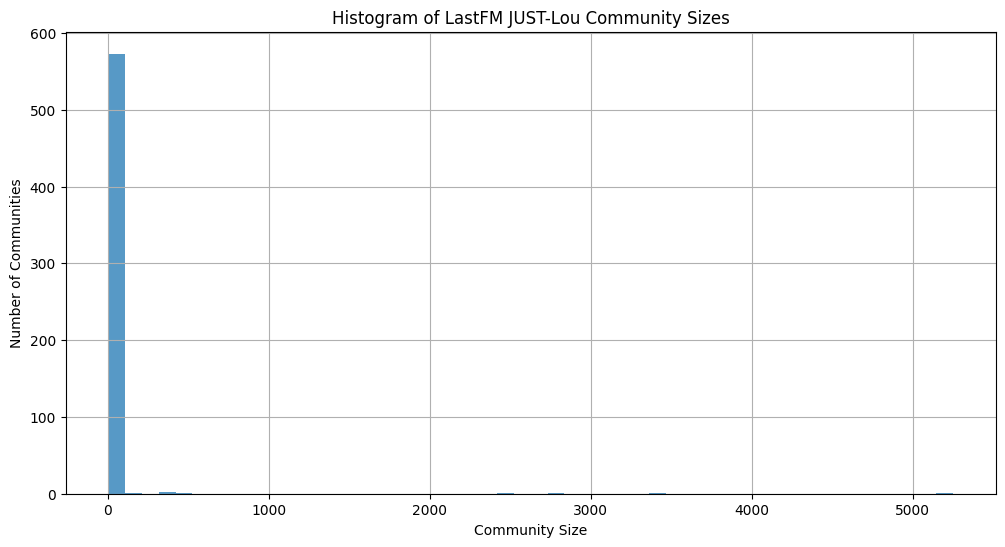

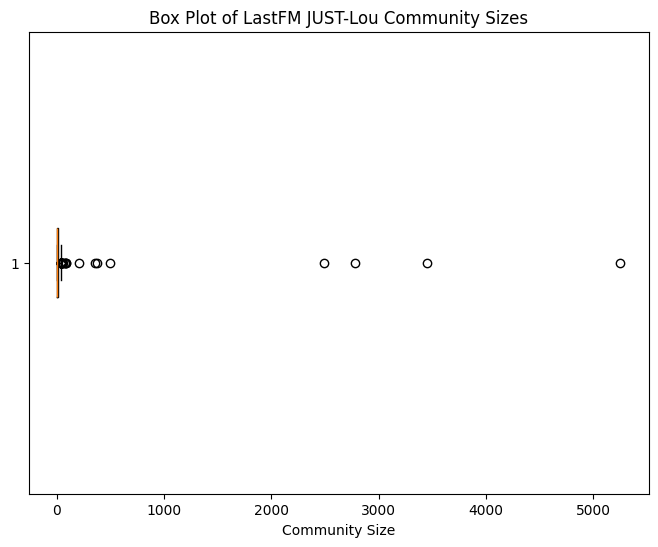

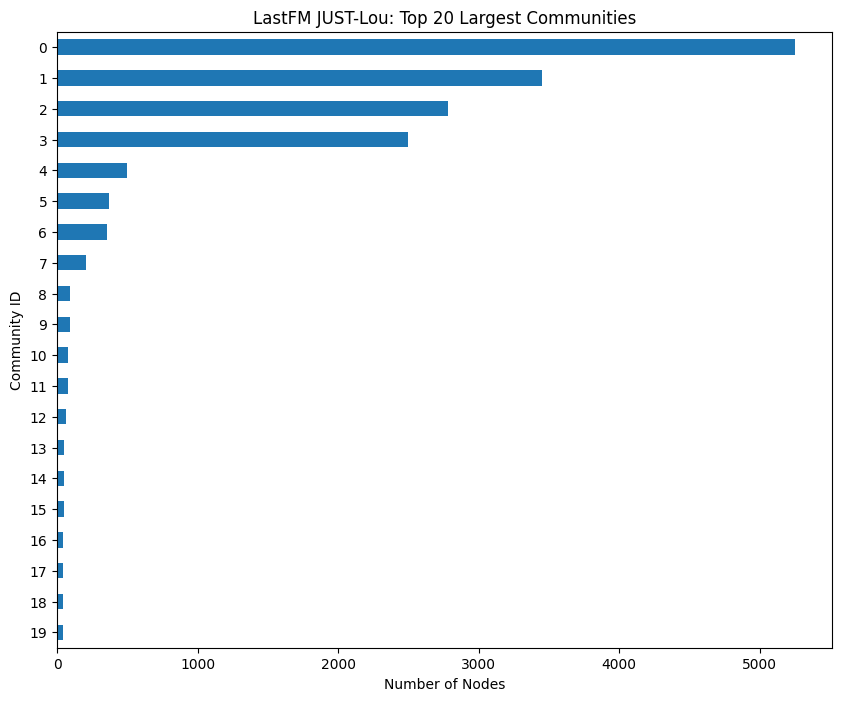

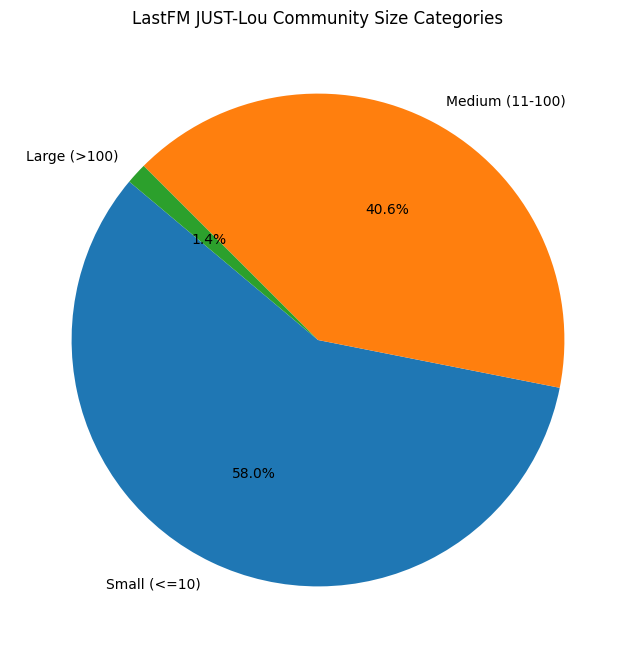

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the size of each community
community_sizes_louvain = node_df_louvain.groupby('communityID').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(community_sizes_louvain, bins=50, alpha=0.75)
plt.title('Histogram of LastFM JUST-Lou Community Sizes')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.show()

# Plot a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(community_sizes_louvain, vert=False)
plt.title('Box Plot of LastFM JUST-Lou Community Sizes')
plt.xlabel('Community Size')
plt.show()

# Plot sizes of the top N communities
top_n = 20
top_communities = community_sizes_louvain.nlargest(top_n).sort_values()
top_communities.plot(kind='barh', figsize=(10, 8))
plt.title(f'LastFM JUST-Lou: Top {top_n} Largest Communities')
plt.xlabel('Number of Nodes')
plt.ylabel('Community ID')
plt.show()

# Plot pie chart
def categorize_size(x):
    if x <= 10:
        return 'Small (<=10)'
    elif x <= 100:
        return 'Medium (11-100)'
    else:
        return 'Large (>100)'

size_categories = community_sizes_louvain.apply(categorize_size).value_counts()

size_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8))
plt.title('LastFM JUST-Lou Community Size Categories')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

#### Specific Community Analysis

In order to determine if the separation of entities into communities actually makes sense, we need to look at the internal components of communities.

In [32]:
community = node_df_louvain[node_df_louvain['communityID'] == 26]
# Count the occurrence of each type within the community
print(community['type'].value_counts())
# List all unique tags or artists within the community
print("Unique tags:", community[community['type'] == 'tag']['name'].unique())
print("Unique artists:", community[community['type'] == 'artist']['name'].unique())

type
artist    30
tag        7
Name: count, dtype: int64
Unique tags: ['j-rock' 'jrock' 'j rock plastic tree' 'j  rock' 'jap rap'
 'rock japanese' 'mixture rock']
Unique artists: ["L'Arc~en~Ciel" "D'espairsRay" 'GACKT' 'ViViD' 'Plastic Tree'
 'exist†trace' 'Dragon Ash' 'UVERworld' 'lynch.' 'ギルガメッシュ' 'LUNA SEA'
 'Dark Schneider' 'Tommy heavenly6' 'An Cafe' 'HIGH and MIGHTY COLOR'
 'MALICE MIZER' 'Sadie' '雅-MIYAVI-' 'Flow' 'hide' 'Janne Da Arc'
 'アンティック-珈琲店-' 'Do As Infinity' 'Ikimono-Gakari' '高橋瞳' '12012' '平野綾'
 'LM.C' '北出菜奈' 'Miz']


We can also look at the distribution of tags across communities, and whether there is a coherent thematic difference between communities. This is partial evidence for a successful detection of community structures.

In [33]:
# Filter out the tag-type nodes
tags_df_louvain = node_df_louvain[node_df_louvain['type'] == 'tag'].copy()

# Group by communityID and tag name, then count occurrences
tag_counts_by_community_louvain = tags_df_louvain.groupby(['communityID', 'name']).size().reset_index(name='count')

# Sort the results within each community by count, descending
tag_counts_by_community_sorted_louvain = tag_counts_by_community_louvain.sort_values(by=['communityID', 'count'], ascending=[True, False])

tag_counts_by_community_sorted_louvain

,communityID,name,count
0,0,'80s,1
1,0,1970,1
2,0,1970's,1
3,0,1970s,1
4,0,1980,1
...,...,...,...
1989,575,dark cabaret,1
1990,576,crossover thrash metal,1
1991,578,russian dark scene,1
1992,579,batcave deathrock,1


We ensure that we select 5 random communities that have at least 1 tag each, otherwise the visualization would not be complete. We look at the top tags in each of those communities to determine whether there are distinctions made.

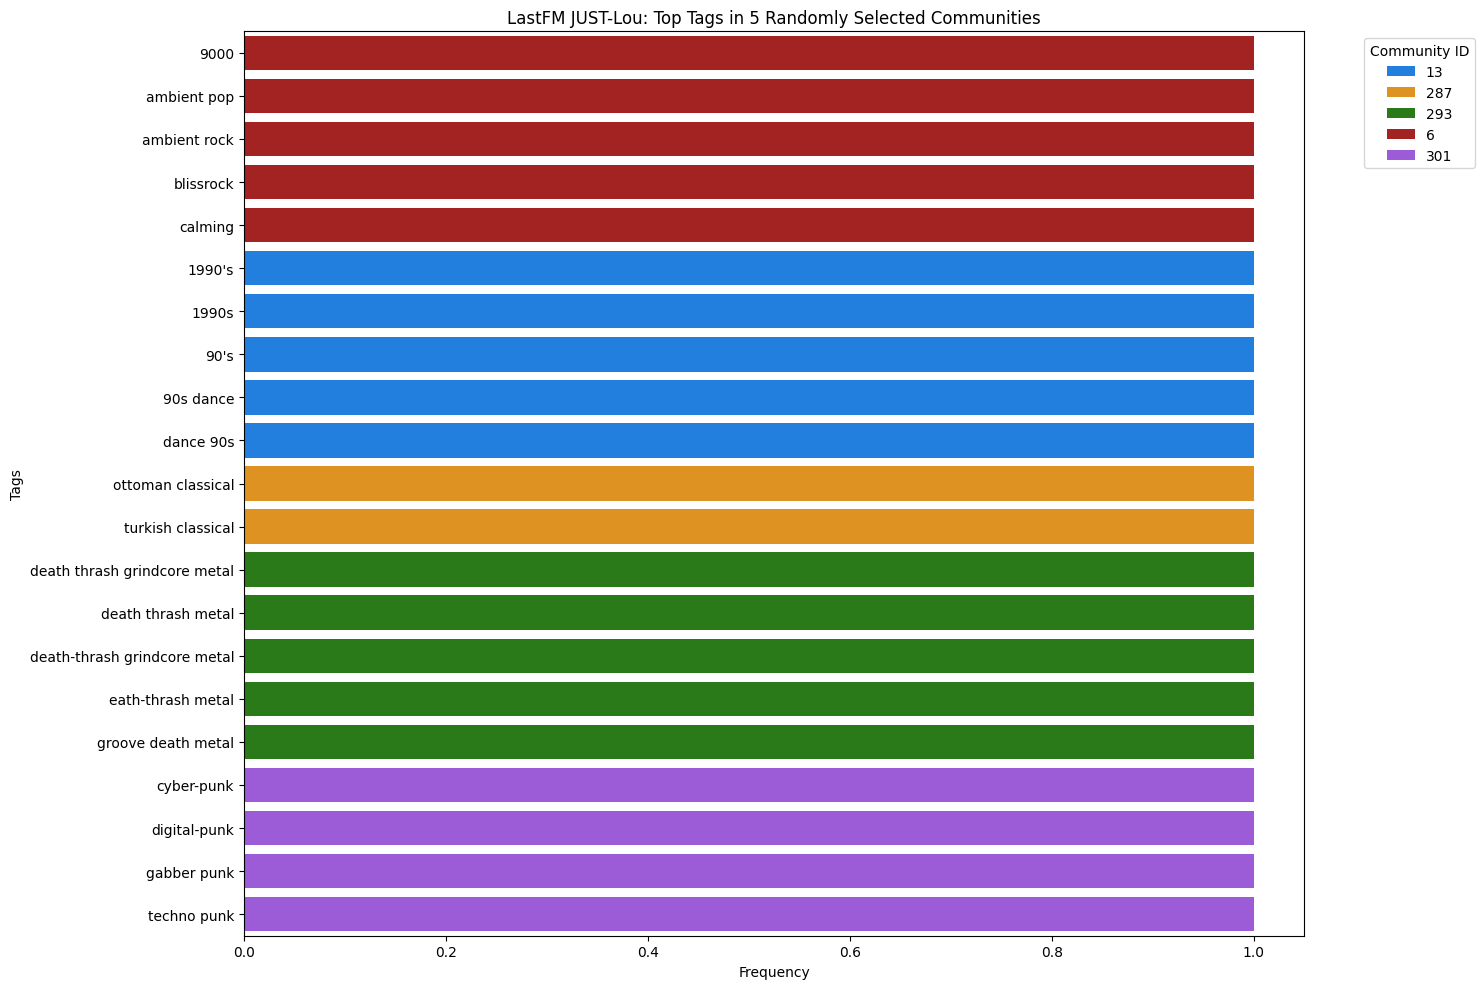

In [84]:
# For each community, select the top N tags to analyze
top_n = 5
top_tags_by_community_louvain = tag_counts_by_community_sorted_louvain.groupby('communityID').head(top_n)

total_tag_counts_by_community = tag_counts_by_community_sorted_louvain.groupby('communityID')['count'].sum().reset_index()

# Set a seed for reproducibility
np.random.seed(3423)

# Identify communities with more than one tag
communities_with_more_than_one_tag = total_tag_counts_by_community[total_tag_counts_by_community['count'] > 1]['communityID'].unique()

custom_colors = ["#037ffc", "#fc9803", "#218a0a", "#b80d0d", "#9d47ed"]

# Check if we have at least 5 such communities
if len(communities_with_more_than_one_tag) >= 5:
    # Randomly select 5 communities that have at least one tag
    selected_communities = np.random.choice(communities_with_more_than_one_tag, 5, replace=False)
else:
    # If there are not enough communities with tags, just take what's available
    selected_communities = communities_with_more_than_one_tag

# Ensure we do not exceed the number of colors available in the custom palette
selected_communities = selected_communities[:len(custom_colors)]

# Filter the top tags for these selected communities
selected_top_tags = top_tags_by_community_louvain[top_tags_by_community_louvain['communityID'].isin(selected_communities)]

# Create a dictionary mapping community IDs to custom colors
color_map = {community: color for community, color in zip(selected_communities, custom_colors)}

import seaborn as sns

# Use the 'hue_order' parameter to ensure the colors match up with the community IDs
# and the 'palette' parameter to apply the custom colors
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='name', hue='communityID', data=selected_top_tags, dodge=False,
            palette=color_map, hue_order=selected_communities)

plt.title('LastFM JUST-Lou: Top Tags in 5 Randomly Selected Communities')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.legend(title='Community ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

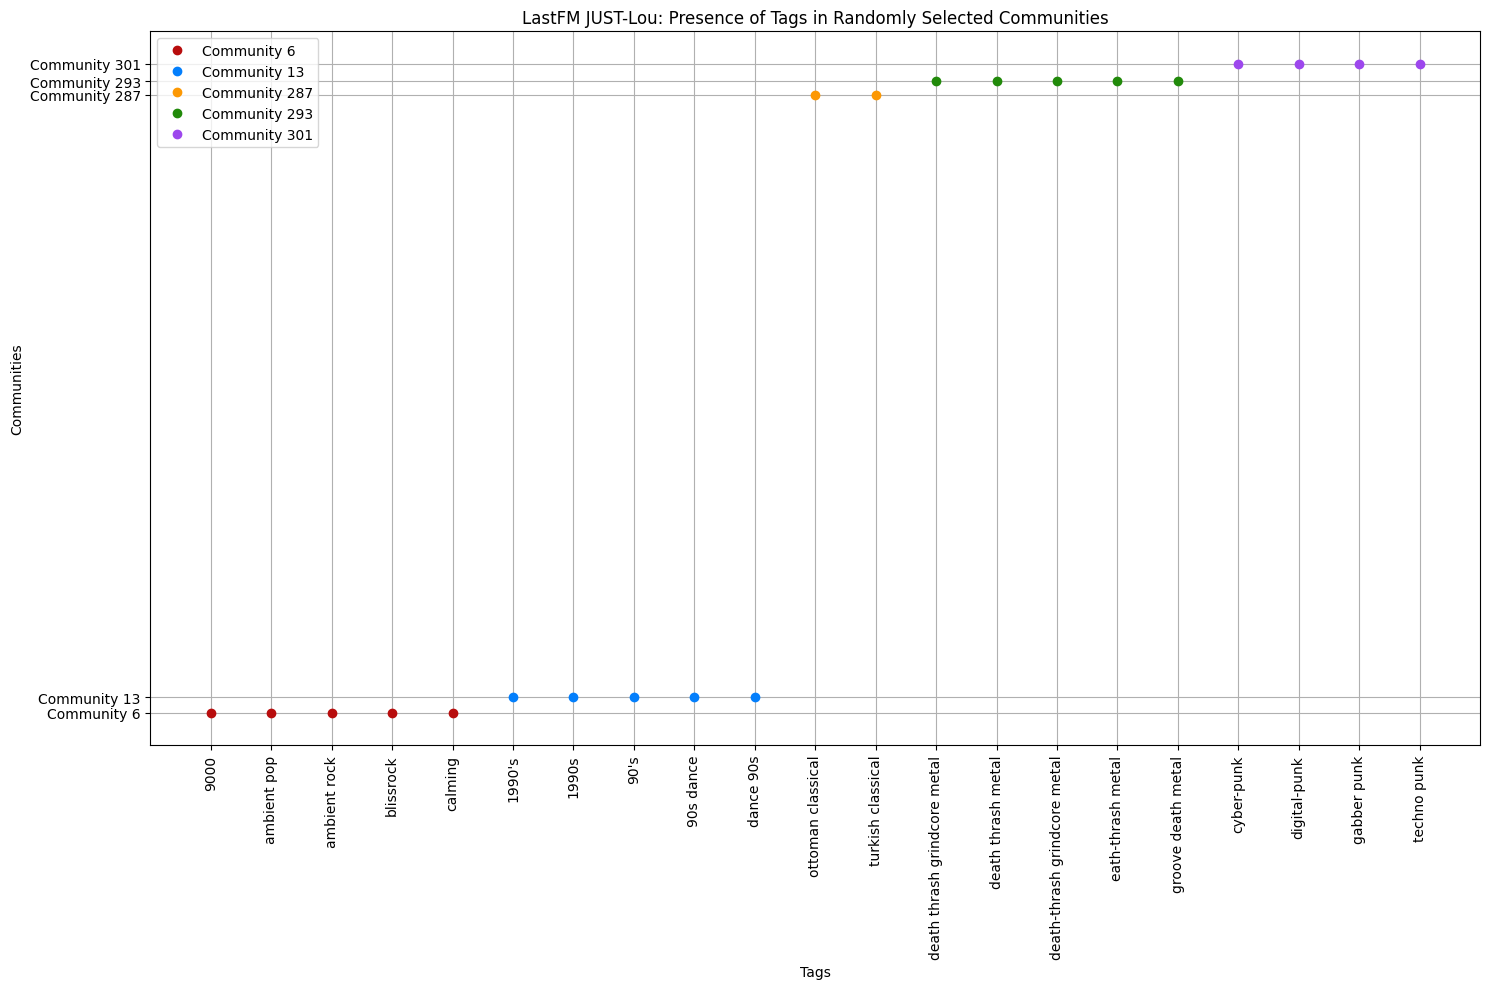

In [85]:
# Assuming 'selected_top_tags' contains the top tags for the selected communities
# Each tag is unique to a community, so we will visualize the presence of tags within communities

# Create a new figure and axis
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Get unique communities and tags for plotting
unique_communities_louvain = selected_top_tags['communityID'].unique()
unique_tags_louvain = selected_top_tags['name'].unique()

# Create a categorical plot
# For each community, we'll plot a line at y=1
for community in unique_communities_louvain:
    # Get the tags for this community
    community_tags = selected_top_tags[selected_top_tags['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='', color=color_map[community])

# Improve the plot aesthetics
ax.set_yticks(unique_communities_louvain)
ax.set_yticklabels([f'Community {id}' for id in unique_communities_louvain])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('LastFM JUST-Lou: Presence of Tags in Randomly Selected Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

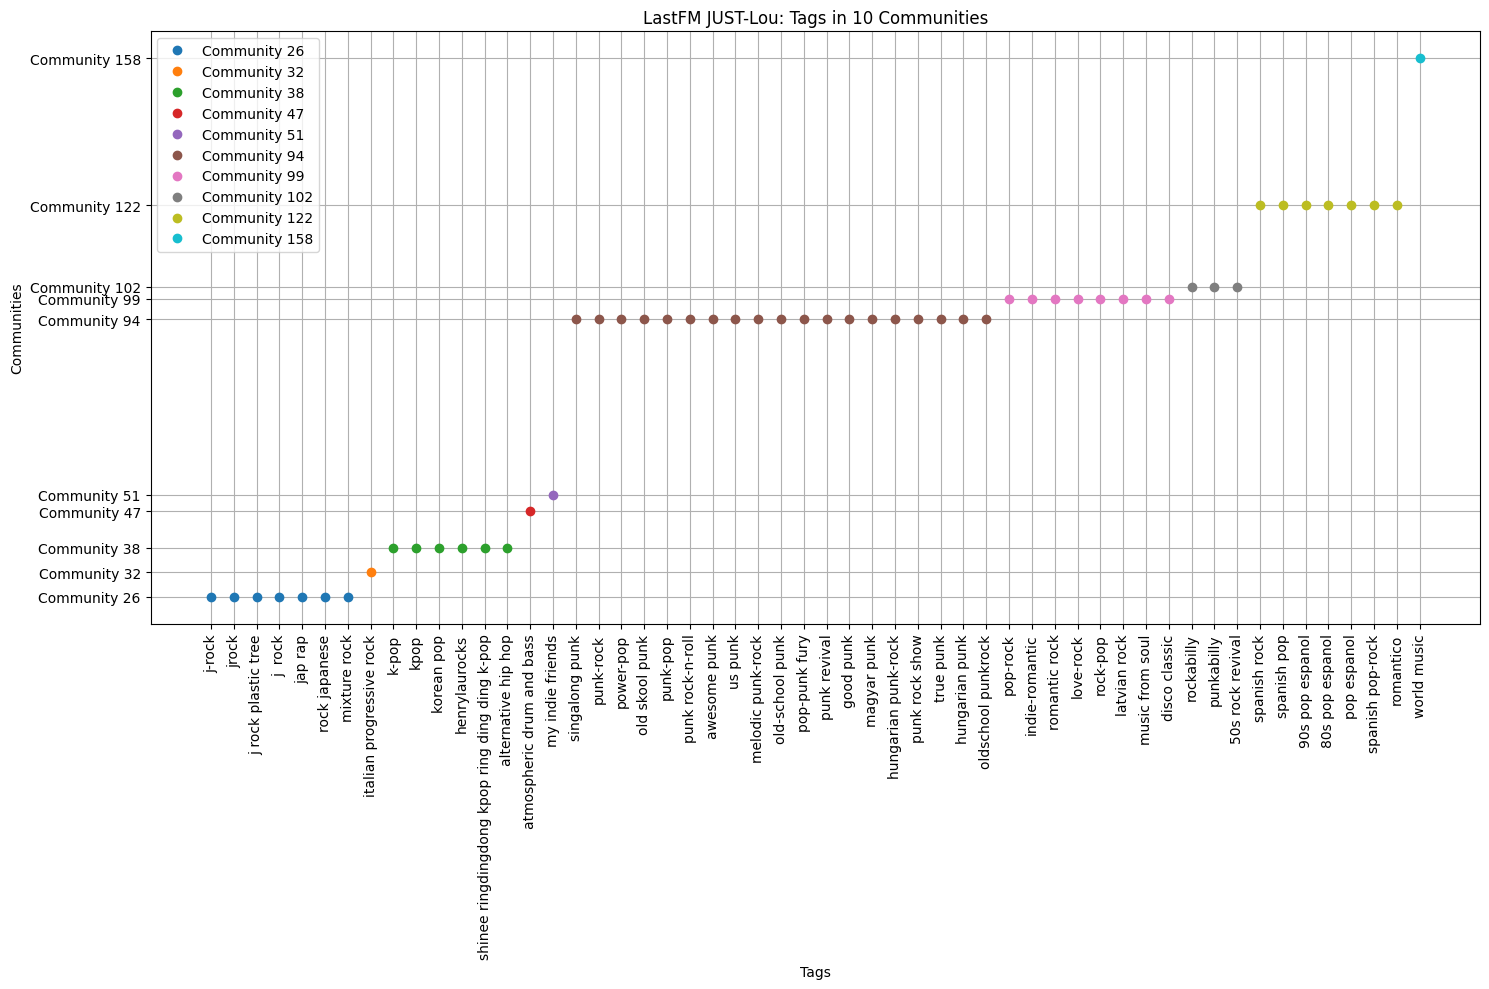

In [89]:
# Get the desired community IDs
first_5_communities = sorted(tags_df_louvain['communityID'].unique())[15:25]

# Filter tags from these communities
first_5_tags = tags_df_louvain[tags_df_louvain['communityID'].isin(first_5_communities)]

# Create a categorical plot to show the tags for each of the first 5 communities
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Plotting
for community in first_5_communities:
    # Get the tags for this community
    community_tags = first_5_tags[first_5_tags['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='')

# Improve the plot aesthetics
ax.set_yticks(first_5_communities)
ax.set_yticklabels([f'Community {id}' for id in first_5_communities])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('LastFM JUST-Lou: Tags in 10 Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

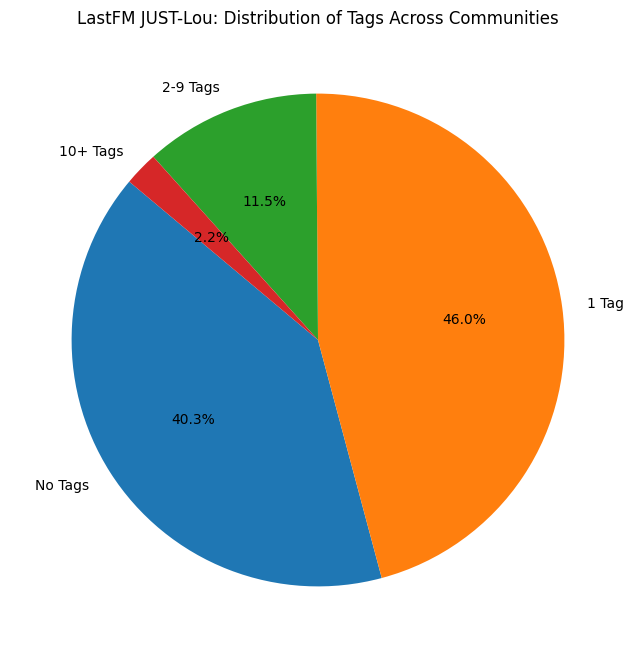

In [68]:
# Categorize each community by the number of tags it contains
counts = node_df_louvain[node_df_louvain['type'] == 'tag']['communityID'].value_counts()

# Define categories
no_tags = (counts == 0).sum()
one_tag = (counts == 1).sum()
less_than_ten_tags = ((counts > 1) & (counts < 10)).sum()
ten_or_more_tags = (counts >= 10).sum()

# Make sure to include communities with no tags
total_communities = node_df_louvain['communityID'].nunique()
no_tags = total_communities - len(counts)

# Prepare data for the pie chart
categories = ['No Tags', '1 Tag', '2-9 Tags', '10+ Tags']
sizes = [no_tags, one_tag, less_than_ten_tags, ten_or_more_tags]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('LastFM JUST-Lou: Distribution of Tags Across Communities')
plt.show()

### **For Leiden**

#### Overview of Community Data

First, we aggregate the data by community ID to get an overview of each community's composition. We group our DataFrame by the community ID and then examine the types and names within each community.


In [28]:
# Group by community ID and list out members of each community
community_groups = node_df_leiden.groupby('communityID')

# Example to print out the composition of each community
for community_id, group in community_groups:
    print(f"Community ID: {community_id}")
    print(f"Members count: {len(group)}")
    print(group[['nodeID', 'name', 'type']].head())  # Adjust as needed
    print("\n")


Community ID: 0
Members count: 4054
  nodeID          name type
2   t_18    electronic  tag
3   t_81         indie  tag
5   t_33  experimental  tag
6  t_292          folk  tag
7   t_14       ambient  tag


Community ID: 1
Members count: 3630
   nodeID              name type
1    t_73              rock  tag
4    t_79       alternative  tag
8    t_78  alternative rock  tag
14  t_181              punk  tag
17    t_1             metal  tag


Community ID: 2
Members count: 2941
   nodeID              name type
20   t_72         hard rock  tag
24  t_387  progressive rock  tag
27  t_192      classic rock  tag
28  t_386       heavy metal  tag
30  t_735               70s  tag


Community ID: 3
Members count: 2514
     nodeID         name type
61    t_199   electropop  tag
88    t_349     teen pop  tag
101  t_7938   pop covers  tag
106   t_202  electro pop  tag
128  t_7937  pop singles  tag


Community ID: 4
Members count: 2351
   nodeID       name type
0    t_24        pop  tag
12   t_25       

We can also get generate a summary table that lists each community ID along with the counts of tags, artists, and users in each community.

In [29]:
community_summary_leiden = node_df_leiden.groupby('communityID')['type'].value_counts().unstack(fill_value=0)

# Calculate the total number of entities in each community
community_summary_leiden['total_entities'] = community_summary_leiden.sum(axis=1)

# Reset the index to turn the index into a column
community_summary_leiden.reset_index(inplace=True)

# Display the summary table
community_summary_leiden

type,communityID,artist,tag,user,total_entities
0,0,3579,281,194,4054
1,1,2988,336,306,3630
2,2,2263,422,256,2941
3,3,1795,189,530,2514
4,4,1955,216,180,2351
5,5,1570,197,288,2055
6,6,1371,125,46,1542
7,7,1068,101,48,1217
8,8,466,51,20,537
9,9,452,44,20,516


#### Specific Community Analysis

In [30]:
community = node_df_louvain[node_df_leiden['communityID'] == 0]
# Count the occurrence of each type within the community
print(community['type'].value_counts())
# List all unique tags or artists within the community
print("Unique tags:", community[community['type'] == 'tag']['name'].unique())
print("Unique artists:", community[community['type'] == 'artist']['name'].unique())

type
artist    3579
tag        281
user       194
Name: count, dtype: int64
Unique tags: ['electronic' 'indie' 'experimental' 'folk' 'ambient' 'chillout'
 'electronica' 'indie pop' 'house' 'post-rock' 'techno' 'trance' 'chill'
 'dark ambient' 'dream pop' 'new age' 'dreamy' 'relaxing' 'drum and bass'
 'progressive trance' 'dubstep' 'post rock' 'dark' 'psytrance'
 'my indie friends' 'barkbarkdisco' 'indietronica' 'space rock'
 'noise pop' 'dreampop' 'nu jazz' 'contemporary classical'
 'psychedelic trance' 'acid jazz' 'noise rock' 'indie folk' 'neofolk'
 'vocal trance' 'synth-pop' 'anti-folk' 'deep house' 'just chillin'
 'math rock' 'light trip-hop' 'in the witch house family'
 'progressive house' 'darkstep' 'berep guest dj closedmouth 239645'
 'in the chillwave family' 'dark disco' 'techno brut' 'post-metal'
 'witch house' 'minimal techno' 'experimental rock' 'music for my soul'
 'chill out' 'freak folk' 'electro house' 'nu-jazz' 'soulful house'
 'dance - trance' 'krautrock' 'blissrock' 